<a href="https://colab.research.google.com/github/hrishipoola/Peloton_Implied_Volatility_Delta_Hedge/blob/main/Peloton's_Implied_Volatility_%26_Delta_Hedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peloton's Implied Volatility & Delta Hedge

## Table of Contents

1. Introduction
2. Investment Thesis
3. Install & Import Packages
4. Collect Data
5. Black Scholes
<br>Parameters
<br>Function
6. Option Premiums
7. Implied Volatility
8. Greeks
9. Delta Hedge
10. References


## 1. Introduction

Today, let's dig into Peloton (ticker: PTON). The purpose of this post is to:
- Forecast PTON's volatility at a point in the future by calculating its [implied volatility](https://www.investopedia.com/terms/i/iv.asp)
- Understand its option price sensitivities through the [Greeks](https://www.investopedia.com/trading/using-the-greeks-to-understand-options/) 
- Create a [delta-neutral](https://www.investopedia.com/terms/d/deltaneutral.asp) portfolio in which price decreases are wholly offset ([delta hedged](https://www.investopedia.com/terms/d/deltahedging.asp)) by a complementary increase in put option value.

In previous posts, we developed more realistic risk forecasts using GARCH models incorporating the time-varying character of volatility. Today, we'll calculate implied volatility for a point in the future using the Black Scholes model to back-calculate sigma based on the market price of a put option. One thing to keep in mind is that Black Scholes makes simplifying assumptions - price follows geometric Brownian motion, returns are normally distributed, zero transaction costs, asset pays no dividends, and risk free rate and volatility are constant. We'll show demonstrate that these assumptions don't actually hold in reality. For example, PTON's returns aren't normally distributed and that its implied volatility relative to strike price isn't constant (a straight line), but curves in a 'volatility smile.' Despite Black Scholes' limitations in option pricing, the model is still useful in practice for determining implied volatility and the Greeks. We could improve our estimates in the future with models that incorporate stochastic volatility (e.g., Heston model).   

We'll calculate the Greeks delta, gamma, vega (not actually a Greek letter), theta, and rho, which are option premium sensitivities (partial derivatives) with respect to specific characteristics of the underlying asset: 

- Delta: change in option price with \$1 change in underlying asset price (velocity) 
- Gamma: change in delta with \$1 change in underlying asset price (acceleration)
- Vega: change in option price with 1% change in implied volatility 
- Theta: change in option price with 1 day change in expiration (time decay)
- Rho: change in option price with 1% change in interest rate 	

We'll dive deeper into delta, looking at how it changes with time to maturity and delta hedging. We'll create a portfolio of Peloton stock and put options that's delta-neutral - that is, a decrease in PTON's price is wholly offset (hedged) by an increase in its put option value. Delta hedging is one strategy we can use if we believe an asset's price will increase long term, but, due to risks, could decrease in the near term. 

Before we dive in, let's unpack our investment thesis and options strategy for Peloton. 








## 2. Investment Thesis

We're bullish on Peloton (ticker: PTON) in the 2-3 year timeframe due to a partial structural shift to in-home workouts, its app community and services, sticky user base (\<1% churn), increasing connected fitness subscriptions, strong cash position, and commercial sales potential in offices, hotels, and apartment complexes. While the upfront \$2500 dollars on a bike is a splurge for most, Peloton also offers 0% financing (through a 3rd party) amortized over 39 months. Not to mention the Apple acquisition rumors. Looking further out Peloton faces non-cycling product innovation pressure as customers aren't likely to make repeat bike purchases (currently, >80% of the company's revenue comes from product sales, not subscriptions). 

Over the next 6 months, Peloton faces supply chain and demand risks that could see its price decrease from its current rich valuation. Supply chain challenges have resulted in ongoing backlogs, recalls, and expenses. While Peloton's recent \$420 million acquisition of Precor and its 625,000 sq ft of U.S. manufacturing will help, it'll take time to integrate. CEO John Foley has stated that the company will need to invest in its supply chain for "years and years." Another near-term risk is moderating demand due to vaccine rollout and warmer weather.   

Put option strategy:

To protect against these downside risks on an existing PTON position, let's buy put options (right to sell) with a \$140 strike price that expires on June 18, 2021 after Peloton reports its fiscal Q3'2021 (calendar Q1'2021) earnings in May 2021. This would effectively give us a guaranteed floor price of \$140. With PTON's spot price currently at \$139, the put option is just about at-the-money with the spot price just about at the strike price (it isn't an aggressive or speculative position). If PTON's price is above \$140 on June 18, 2021, we simply won't exercise our option. If it's below \$140, we've guaranteed this floor price and protected against downside risk according to our risk tolerance. We'll see that at the $140 strike, the implied volatility is low and we believe it will go higher, meaning the option is undervalued and a good buy. Keep in mind, an options contract is for 100 shares of the underlying asset. 

We'll see at the end that combination of 170 shares of PTON and 4 put options (priced at $4.41 each) would get us to delta-neutral where any decrease in PTON's price would be offset by an equivalant increase in option value. 

If there's anything we could improve our if you'd like to share ideas, reach out! We've also included references at the end if you'd like to learn more. 


## 3. Install & Import Packages

In [ ]:
!pip install yfinance
!pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
import yfinance as yf
!pip install yahoo_fin
import yahoo_fin
from yahoo_fin import options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats
from scipy.stats import norm
from math import log, sqrt, pi, exp

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 4. Collect Data

### Stock Data

In [ ]:
def peloton_prices_returns(ticker, start_date, end_date):
  global peloton
  peloton = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)[['Adj Close']]
  peloton['return'] = peloton.pct_change()
  peloton.dropna(inplace=True)
  return peloton

peloton_prices_returns('PTON','2019-09-26','2021-02-19') # Peloton IPO'd on September 26, 2019

,Adj Close,return
Date,,
2019-09-27,25.240000,-0.020186
2019-09-30,25.100000,-0.005547
2019-10-01,22.510000,-0.103187
2019-10-02,22.600000,0.003998
2019-10-03,22.330000,-0.011947
2019-10-04,23.010000,0.030452
2019-10-07,23.510000,0.021730
2019-10-08,23.209999,-0.012761
2019-10-09,24.000000,0.034037


Text(2020-07-25 00:00:00, 167.4199981689453, 'To acquire Precor for $420M')

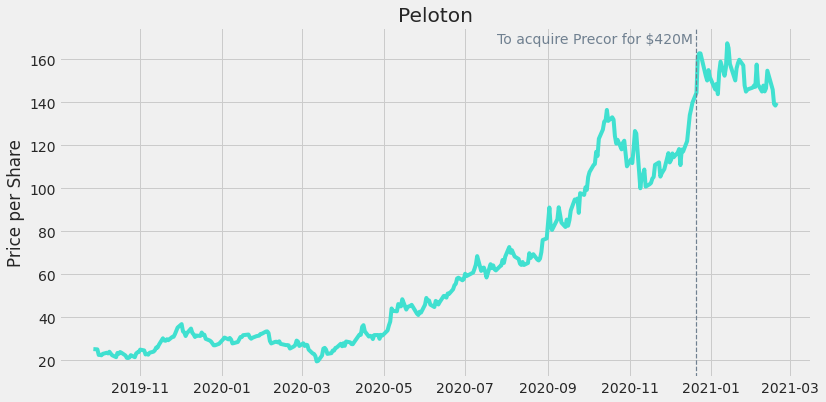

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(peloton['Adj Close'], color='turquoise')
ax.set(title='Peloton', ylabel='Price per Share') 
ax.axvline(pd.to_datetime('2020-12-21'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-07-25'), max(peloton['Adj Close']), 'To acquire Precor for $420M', color='slategray')

[Text(0.5, 1.0, 'Distribution of Returns')]

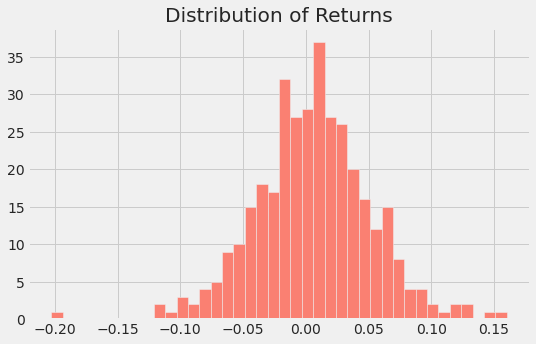

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(peloton['return'], color='salmon', bins=40)
ax.set(title='Distribution of Returns')

The distribution of returns isn't exactly normal with its fatter tails and slight skew, conflicting with Black Scholes assumption of normally distributed returns. 

### Options Data

In [ ]:
# Get expiration dates
expiration_dates = options.get_expiration_dates("pton")
expiration_dates

['February 26, 2021',
 'March 5, 2021',
 'March 12, 2021',
 'March 19, 2021',
 'March 26, 2021',
 'April 1, 2021',
 'April 16, 2021',
 'June 18, 2021',
 'July 16, 2021',
 'September 17, 2021',
 'October 15, 2021',
 'January 21, 2022',
 'January 20, 2023']

In [ ]:
# Get options data for each expiration date
expiration_dates= options.get_expiration_dates('pton')

options_chain = {}
for date in expiration_dates:
    options_chain[date] = options.get_options_chain('pton')

In [ ]:
# Options info for June 18, 2021 expiration call options
calls = options_chain['June 18, 2021']['calls']
calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,PTON210226C00075000,2021-02-17 9:37AM EST,75.0,65.75,0.0,0.0,0.0,-,2,10,0.00%
1,PTON210226C00085000,2021-02-17 9:37AM EST,85.0,55.75,0.0,0.0,0.0,-,2,4,0.00%
2,PTON210226C00090000,2021-02-17 9:44AM EST,90.0,51.60,0.0,0.0,0.0,-,1,1,0.00%
3,PTON210226C00095000,2021-02-09 9:32AM EST,95.0,52.55,0.0,0.0,0.0,-,1,14,0.00%
4,PTON210226C00096000,2021-02-19 10:54AM EST,96.0,44.80,0.0,0.0,0.0,-,3,3,0.00%
5,PTON210226C00100000,2021-02-04 10:56AM EST,100.0,46.55,0.0,0.0,0.0,-,1,2,0.00%
6,PTON210226C00105000,2021-02-19 3:15PM EST,105.0,34.24,0.0,0.0,0.0,-,1,5,0.00%
7,PTON210226C00108000,2021-02-19 12:02PM EST,108.0,33.40,0.0,0.0,0.0,-,1,2,0.00%
8,PTON210226C00110000,2021-02-17 3:44PM EST,110.0,29.40,0.0,0.0,0.0,-,2,8,0.00%
9,PTON210226C00111000,2021-02-18 11:52AM EST,111.0,29.10,0.0,0.0,0.0,-,-,2,0.00%


In [ ]:
# Options info for June 18, 2021 expiration put options
puts = options_chain['June 18, 2021']['puts']
puts

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,PTON210226P00075000,2021-02-17 1:08PM EST,75.0,0.05,0.00,0.0,0.0,-,5,34,50.00%
1,PTON210226P00080000,2021-02-17 11:38AM EST,80.0,0.05,0.00,0.0,0.0,-,10,62,50.00%
2,PTON210226P00085000,2021-02-19 11:49AM EST,85.0,0.01,0.00,0.0,0.0,-,1,15,50.00%
3,PTON210226P00090000,2021-02-19 1:55PM EST,90.0,0.03,0.00,0.0,0.0,-,1,6,50.00%
4,PTON210226P00095000,2021-02-17 12:12PM EST,95.0,0.13,0.00,0.0,0.0,-,6,19,50.00%
5,PTON210226P00100000,2021-02-19 2:47PM EST,100.0,0.04,0.00,0.0,0.0,-,86,249,50.00%
6,PTON210226P00105000,2021-02-12 2:26PM EST,105.0,0.08,0.00,0.0,0.0,-,1,35,50.00%
7,PTON210226P00110000,2021-02-19 3:34PM EST,110.0,0.07,0.00,0.0,0.0,-,80,301,50.00%
8,PTON210226P00114000,2021-02-19 3:53PM EST,114.0,0.10,0.00,0.0,0.0,-,1,1,50.00%
9,PTON210226P00115000,2021-02-19 3:49PM EST,115.0,0.14,0.00,0.0,0.0,-,66,839,50.00%


## 5. Black Scholes

### Parameters

#### Spot Price (S)

In [ ]:
# S is the current spot price of underlying stock
S = peloton['Adj Close'].iloc[-1]
S

139.7100067138672

#### Strike Price (X)

In [ ]:
X = 140

#### Time to Maturity (T)

In [ ]:
# T is the time until maturity (in fractions of a year)
expiry = '07-16-2021'
today = datetime.now()
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.now()).days / 365
T

0.3917808219178082

#### Risk-Free Rate (r)

In [ ]:
# r is the risk free rate, which we'll use as the 10-year U.S. Treasury Yield '^TNX'
today = datetime.now()
r = (pdr.get_data_yahoo('^TNX')['Adj Close'].iloc[-1]) / 100
r

0.013450000286102295

Risk free rate is 1.34%

#### Volatility (sigma)

In [ ]:
def sigma(df):
  daily_volatility = df['return'].std()
  yearly_trade_days = 252
  sigma = np.sqrt(yearly_trade_days) * daily_volatility
  return sigma

sigma(peloton)

0.7276810144520266

In [ ]:
# S is the current spot price of underlying stock
S = peloton['Adj Close'].iloc[-1]

# X is the option strike price
X = 140

# T is the time until maturity (in fractions of a year)
expiry = '06-18-2021'
today = datetime.now()
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.now()).days / 365

# r is the risk free rate, which we'll use as the 10-year U.S. Treasury Yield '^TNX'
today = datetime.now()
r = (pdr.get_data_yahoo('^TNX')['Adj Close'].iloc[-1]) / 100

# sigma is the yearly returns volatility of the underlying stock
daily_volatility = peloton['return'].std()
yearly_trade_days = 252
sigma = np.sqrt(yearly_trade_days) * daily_volatility

# option_type is the option type, either 'call' or 'put'

### Define Function

In [ ]:
# http://janroman.dhis.org/stud/I2014/BS2/BS_Daniel.pdf

# d1 is the probability of receiving the stock at expiration 
def d11(S, X, T, r, sigma):
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# d2 is the risk-adjusted probability that the option will be exercised
def d21(d1, T, sigma):
    return d1 - sigma * np.sqrt(T)

# Black-Scholes European option pricing formula    
def black_scholes(S, X, T, r, sigma, option_type):
    global d_one, d_two
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

## 6. Option Premiums

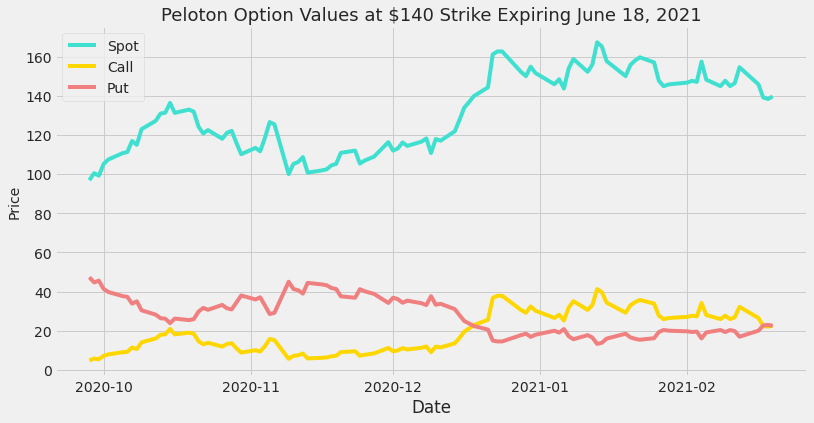

In [ ]:
# Last 100 spot prices
peloton_spot = peloton['Adj Close'][-100:]

# Initialize the European put option values array
call_option_values = np.zeros(peloton_spot.size)
put_option_values = np.zeros(peloton_spot.size)

# Iterate through spot prices and compute the option values
for i,S in enumerate(peloton_spot.values):
    call_option_values[i] = black_scholes(S = S, X = X, T = T, r = r, sigma = sigma, option_type = 'call')
    put_option_values[i] = black_scholes(S = S, X = X, T = T, r = r, sigma = sigma, option_type = 'put')

options_values=pd.DataFrame({'spot_price':peloton_spot, 'call_option_value':call_option_values, 'put_option_value':put_option_values})

plt.figure(figsize=(12,6))
sns.lineplot(data=options_values['spot_price'], color='turquoise')
sns.lineplot(data=options_values['call_option_value'], color='gold')
sns.lineplot(data=options_values['put_option_value'], color='lightcoral')
plt.ylabel('Price', fontsize=14)
plt.title('Peloton Option Values at $140 Strike Expiring June 18, 2021', fontsize=18)
plt.legend(labels=['Spot','Call','Put'])

As we'd expect, call premium rise with increasing spot price while put premiums fall with increasing spot price. 

In [ ]:
# Call option premium
price_call = black_scholes(S = S, X = X, T = T, r = r, sigma = sigma, option_type = 'call')
price_call

22.735323612036936

In [ ]:
# Put option premium
price_put = black_scholes(S = S, X = X, T = T, r = r, sigma = sigma, option_type = 'put')
price_put

22.433298189248653

## 7. Implied Volatility

In [ ]:
def call_implied_volatility(Price, S, X, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = black_scholes(S=S, X=X, T=T, r=r, sigma=sigma, option_type='call')
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

def put_implied_volatility(Price, S, X, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = black_scholes(S=S, X=X, T=T, r=r, sigma=sigma, option_type='put')
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

In [ ]:
print("Put Implied Volatility: " + str(round(100 * put_implied_volatility(puts[puts['Strike']==X]['Last Price'].values[0], S, X, T, r),2))+ " %")

Put Implied Volatility: 14.6 %


Based on market option prices, PTON's forecasted volatility for June 18, 2021 is 14.6%. 

### Volatility Smile

Text(0.5, 1.0, 'Implied Volatility for Put Option Expiring June 18, 2021')

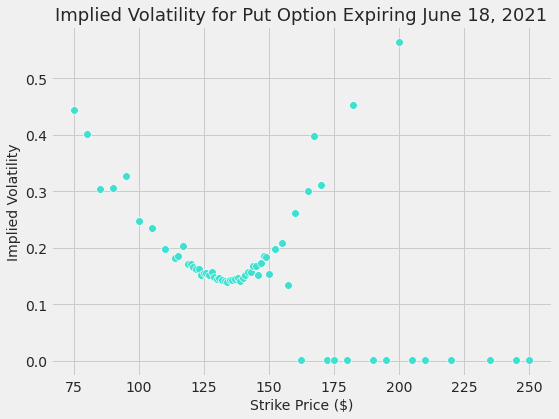

In [ ]:
strikes = puts['Strike']

# Initialize implied volatilty (IV) array
put_IV = np.zeros(strikes.size)

# Iterate through strike prices and compute the implied volatility
for i,X in enumerate(strikes.values):
  put_IV[i] = put_implied_volatility(puts[puts['Strike']==X]['Last Price'].values[0], S, X, T, r)
  
IV_values=pd.DataFrame({'strike_price':strikes, 'put_implied_volatility':put_IV})

plt.figure(figsize=(8,6))
sns.scatterplot(data=IV_values, x='strike_price', y='put_implied_volatility', color='turquoise', s=60)
plt.xlabel('Strike Price ($)', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)
plt.title('Implied Volatility for Put Option Expiring June 18, 2021', fontsize=18)

As we can see from the curve (volatility smile), volatility isn't constant, but changes with strike price. Our put option implied volatility isn't toward the minimum implied volatility. 

## 8. Greeks

In [ ]:
# https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

# Set parameters again as we iterated through them before
S = peloton['Adj Close'].iloc[-1]
X = 140
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.now()).days / 365
r = (pdr.get_data_yahoo('^TNX')['Adj Close'].iloc[-1]) / 100
sigma = np.sqrt(yearly_trade_days) * daily_volatility

def put_greeks(S, X, T, r, sigma, d1):
  # Returns dataframe of greeks 

  global greeks_df

  delta = -norm.cdf(-d11(S,X,T,r,sigma))
  gamma = norm.pdf(d11(S,X,T,r,sigma))/(S*sigma*sqrt(T))
  vega = 0.01*(S*norm.pdf(d11(S,X,T,r,sigma))*sqrt(T))
  theta = 0.01*(-(S*norm.pdf(d11(S,X,T,r,sigma))*sigma)/(2*sqrt(T)) + r*X*exp(-r*T)*norm.cdf(-d21(d1,T,sigma)))
  rho = 0.01*(-X*T*exp(-r*T)*norm.cdf(-d21(d1,T,sigma)))

  greeks_dict = {'Delta: change in option price with $1 change in underlying asset price (velocity)':delta, 
                 'Gamma: change in delta with $1 change in underlying asset price (acceleration)':gamma, 
                 'Vega: change in option price with 1% change in implied volatility':vega,
                 'Theta: change in option price with 1 day change toward expiration (time decay)':theta,
                 'Rho: change in option price with 1% change in interest rate':rho}
  greeks_df = pd.DataFrame.from_dict(greeks_dict, orient='index', columns=['Greeks'])
  return greeks_df

put_greeks(S=S, X=X, T=T, r=r,sigma=sigma,d1=d_one)

,Greeks
Delta: change in option price with $1 change in underlying asset price (velocity),-0.417019
Gamma: change in delta with $1 change in underlying asset price (acceleration),0.006839
Vega: change in option price with 1% change in implied volatility,0.306060
Theta: change in option price with 1 day change toward expiration (time decay),-0.334688
Rho: change in option price with 1% change in interest rate,-0.439231


**Delta**

Delta is positive for long (buying) call options and negative for long (buying) put options. For our put option, delta gets closer to -1 the more in-the-money we are and closer to 0 the more out-of-the-money we are, while -0.5 indicates at-the-money. For a put option, the closer to -1 delta gets, the closer the option follows the underlying asset. 

Our delta of -0.42 implies that for every \$1 increase in PTON's price, the option value declines by 0.42 (and vice versa). Another way to interpret this is that at this point in time, there's a 42% chance that the stock price will be below the strike price (in-the-money) at expiration. 

Keep in mind, delta changes over time - as expiration approaches and the option becomes more likely to expire in-the-money, delta moves closer to -1. 

**Gamma**

Gamma indicates that our delta changes by 0.006 for every $1 change in PTON's price. Gamma is low currently because we are still a ways away from our expiration date Jun 18, 2021. 

**Vega**

Vega is always positive for long option positions as increasing implied volatility increases option premiums. Vega indicates that our option value increases by 0.31 for every 1% increase in implied volatility. 

**Theta**

Theta is a measure of time decay as our option can only be exercised in the future, meaning loss in the time-value of money. It's negative for long option positions (buying) and positive for short option positions (writing). Our theta implies our option value declines 0.33 for each day we hold it. 




Let's plot delta over different times to maturity from the options chain to illustrate how delta changes over time. 

In [ ]:
# Convert string dates to datetime and then to annualized form
def convert_timestamp(x, from_pattern, to_pattern):
  expiration_dates = datetime.strptime(x, from_pattern)
  return datetime.strftime(expiration_dates, to_pattern)

expiration_dates = [convert_timestamp(x, '%B %d, %Y', '%m-%d-%Y') for x in expiration_dates]
expiration_dates = [((datetime.strptime(T, "%m-%d-%Y") - datetime.now()).days / 365) for T in expiration_dates]
expiration_dates = pd.Series(expiration_dates)

Text(0.5, 1.0, 'Delta for Put Option by Time to Expiry')

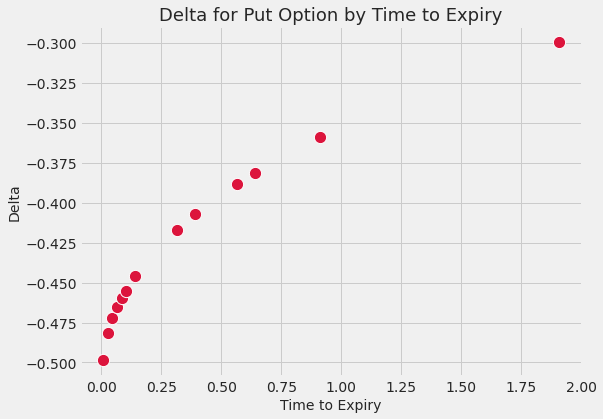

In [ ]:
# Initialize delta array
put_delta = np.zeros(expiration_dates.size)

# Iterate through strike prices and compute the implied volatility
for i,T in enumerate(expiration_dates.values):
  put_delta[i] = -norm.cdf(-d11(S,X,T,r,sigma))
  
delta_values=pd.DataFrame({'expiration_date':expiration_dates, 'delta':put_delta})

plt.figure(figsize=(8,6))
sns.scatterplot(data=delta_values, x='expiration_date', y='delta', color='crimson', s=150)
plt.xlabel('Time to Expiry', fontsize=14)
plt.ylabel('Delta', fontsize=14)
plt.title('Delta for Put Option by Time to Expiry', fontsize=18)

Delta changes over time - as expiration approaches and the put option becomes more likely to expire in-the-money, delta moves closer to -1 at which point it follows lock-step the underlying asset.

## 9. Delta Hedge

Let's say we have 170 shares of PTON. Let's find out how many put options we need to buy to get to delta-neutral. 

In [ ]:
# Set parameters again as we iterated through them before
S = peloton['Adj Close'].iloc[-1]
X = 140
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.now()).days / 365
r = (pdr.get_data_yahoo('^TNX')['Adj Close'].iloc[-1]) / 100
sigma = np.sqrt(yearly_trade_days) * daily_volatility

def delta_neutral(shares):
  # returns statement of number of options needed for delta hedge based on number of shares of underlying asset

  asset_delta = 1
  asset_total_delta = shares * asset_delta
  option_delta = greeks_df.iloc[0,0]
  option_total_delta = -asset_total_delta
  shares_per_option = 100

  global n
  n = option_total_delta / option_delta / shares_per_option
  return print('We need to buy {} put options for a delta-neutral position.'.format(round(n)))

delta_neutral(170)

We need to buy 4 put options for a delta-neutral position.


Our delta neutral portfolio would be 170 shares of PTON and 4 put options. 

In [ ]:
# Market price of put option at our strike price
option_price = puts[puts['Strike']==X]['Last Price'].values[0]
print('Price of put options contract is ${}'.format(option_price))
print('Option contract value (cash outlay) to delta hedge Peloton is ${}'.format(round(n * option_price * 100),2)) 

Price of put options contract is $4.41
Total contract value (cash outlay) to delta hedge Peloton is $1798


The contract value (cash outlay) for PTON shares would be 170 shares x \$139 per share = $23,630

The option is priced at \$4.41. To guarantee a floor price of \$140 per share for PTON, we would pay 4 x \$4.41 x 100 shares = \$1,798 (contract value). 

Another way to check our hedge is to see what would happen if PTON price declined by \$1:

In [ ]:
value = black_scholes(S = S, X = X, T = T, r = r, sigma = sigma, option_type = 'put')
option_delta = greeks_df.iloc[0,0]

# Find the option value change when the price decrease by 1
value_change = black_scholes(S = S-1, X = X, T = T, r = r, sigma = sigma, option_type = 'put') - value

# Total change of both stock and option
-1 + (value_change / abs(option_delta))

0.008229642498508882

We see that even if the price declines by $1, the delta neutral portfolio of both the option and the stock would be virtually unchanged. 



## 10. References


https://www.researchgate.net/post/Is-the-Black-Scholes-formula-an-invalid-optionpricing-model

https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

https://aaronschlegel.me/black-scholes-formula-python.html

https://github.com/YuChenAmberLu/Options-Calculator/blob/master/Options%20Calculator%20with%20Black%20Scholes%20model.ipynb

https://www.investopedia.com/ask/answers/060115/how-implied-volatility-used-blackscholes-formula.asp

http://kevinpmooney.blogspot.com/2017/07/calculating-implied-volatility-from.html

https://www.youtube.com/watch?v=Jpy3iCsijIU&t=6s```

http://theautomatic.net/2019/04/17/how-to-get-options-data-with-python/

https://aaronschlegel.me/measure-sensitivity-derivatives-greeks-python.html

https://www.investopedia.com/terms/d/delta.asp

https://www.investopedia.com/trading/getting-to-know-the-greeks/

https://www.optionsplaybook.com/options-introduction/option-greeks/

https://www.optiontradingtips.com/greeks/delta.html

https://www.investopedia.com/ask/answers/042115/when-put-option-considered-be-money.asp

https://www.quantconnect.com/tutorials/introduction-to-options/historical-volatility-and-implied-volatility


